
=== Dataset Loaded ===

=== Hyperparameter Tuning (Manual) ===
C=0.01, penalty=l1, solver=liblinear => ROC-AUC: 0.9600
C=0.01, penalty=l1, solver=saga => ROC-AUC: 0.9596
C=0.01, penalty=l2, solver=liblinear => ROC-AUC: 0.9606
C=0.01, penalty=l2, solver=saga => ROC-AUC: 0.9599
C=0.1, penalty=l1, solver=liblinear => ROC-AUC: 0.9565
C=0.1, penalty=l1, solver=saga => ROC-AUC: 0.9564
C=0.1, penalty=l2, solver=liblinear => ROC-AUC: 0.9565
C=0.1, penalty=l2, solver=saga => ROC-AUC: 0.9564
C=1, penalty=l1, solver=liblinear => ROC-AUC: 0.9563
C=1, penalty=l1, solver=saga => ROC-AUC: 0.9562
C=1, penalty=l2, solver=liblinear => ROC-AUC: 0.9562
C=1, penalty=l2, solver=saga => ROC-AUC: 0.9562
C=10, penalty=l1, solver=liblinear => ROC-AUC: 0.9563
C=10, penalty=l1, solver=saga => ROC-AUC: 0.9561
C=10, penalty=l2, solver=liblinear => ROC-AUC: 0.9561
C=10, penalty=l2, solver=saga => ROC-AUC: 0.9561

=== Best Hyperparameters ===
{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC-AUC: 0.9606



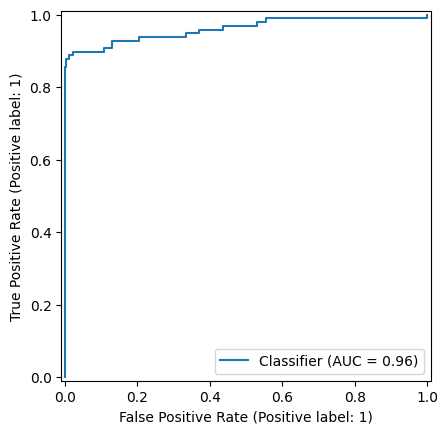

In [2]:
# For inline plotting in Jupyter
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from itertools import product

# ========================= Load Dataset =========================
df = pd.read_csv(r"C:\Users\NEVIN\PycharmProjects\DataPreprocessing\Group_ID\data\raw\creditcard.csv")
print("\n=== Dataset Loaded ===")

# ========================= Handle Missing Values =========================
if df.isnull().sum().sum() > 0:
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

# ========================= Encode Categorical Variables =========================
categorical_cols = df.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

# ========================= Outlier Handling =========================
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('Class', errors='ignore')
for col in num_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = np.clip(df[col], lower, upper)

# ========================= Feature Engineering =========================
if 'Amount' in df.columns and 'Time' in df.columns:
    df['Amount_per_Time'] = df['Amount'] / (df['Time'] + 1)

# ========================= Feature Selection (Mutual Information) =========================
X_temp = df.drop('Class', axis=1)
y_temp = df['Class']
mi_scores = mutual_info_classif(X_temp, y_temp, random_state=42)
mi_series = pd.Series(mi_scores, index=X_temp.columns).sort_values(ascending=False)
selected_features = mi_series[mi_series > 0].index.tolist()

X = df[selected_features]
y = df['Class']

# ========================= Train/Test Split + Scaling =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========================= Apply SMOTE on Training Set =========================
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

# ========================= Manual Hyperparameter Tuning =========================
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

best_auc = 0
best_params = None
best_model = None

print("\n=== Hyperparameter Tuning (Manual) ===")

for C, penalty, solver in product(param_grid['C'], param_grid['penalty'], param_grid['solver']):
    try:
        model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=1000, random_state=42)
        model.fit(X_train_res, y_train_res)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_prob)

        print(f"C={C}, penalty={penalty}, solver={solver} => ROC-AUC: {auc:.4f}")

        if auc > best_auc:
            best_auc = auc
            best_params = {'C': C, 'penalty': penalty, 'solver': solver}
            best_model = model
    except Exception as e:
        # Skip invalid parameter combinations (e.g., solver doesn't support l1)
        continue

print("\n=== Best Hyperparameters ===")
print(best_params)
print(f"Best ROC-AUC: {best_auc:.4f}")

# ========================= Evaluate Best Model =========================
y_pred = best_model.predict(X_test_scaled)
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\n=== Test ROC AUC Score ===\n{roc_auc:.4f}")

# ========================= Plot ROC Curve =========================
RocCurveDisplay.from_predictions(y_test, y_pred_prob)
